Análise do dia 01/04 através do modelo LDA.

In [1]:
# Importar bibliotecas

# gerais
import sys
import os
from pathlib import Path
import re
import numpy as np
import pandas as pd
from pprint import pprint
from tqdm import tqdm
from ast import literal_eval

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore

# NLTK Stop words
import nltk
from nltk.corpus import stopwords

#plot
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

In [2]:
# Criando stopwords em português utilizando a biblioteca nltk

nlp = spacy.load("pt_core_news_sm")
pt_stopwords = sorted([token.text for token in nlp.vocab if token.is_stop])
list_exclude = ['obrigado', 'bom', 'mal', 'nenhuma', 'maior', 
             'bem', 'não', 'máximo', 'boa', 'mais',
               'bastante', 'certamente', 'certeza', 'contra',
                'quarentena', 'coronavírus', 'presidente', 'impeachment', 'demitido', 'demitida']
for word in list_exclude:
    nlp.vocab[word].is_stop = False
list_include = set(['o', 'a', 'tá', 'ta', 'ser', 'pro', 'to', 'tô', 'vc', 'você', 'voce', 'pra',
                    'pq', 'é', 'vou', 'que','tão', 'gt', 'de', 'da', 'do', 'em', 'uma', 'lá',
                    'já', 'no', 'para', 'na', 'com', 'um', 'minha', 'se', 'isso', 'por', 'vou',
                    'os', 'isso', 'como', 'mesmo', 'tenho', 'aqui', 'ele', 'ela', 'quem', 'fazer',
                    'eu', 'só', 'ai', 'mais', 'só', 'querer', 'https', 'ter', 'estar', 'ficar',
                    'dos', 'das', 'vcs', 'jairbolsonaro', 'tava', 'nao', 'sao', 'ja', 'so', 'nossa',
                    'nosso', 'estao', 'tco', 'me', 'dia', 'te', 'ver', 'sera', 'porra', 'fez', 'ne',
                    'kkkkkk', 'puta', 'kkkkkkkk', 'hj', 'afff', 'gbr', 'meu', 'cara', 'guri', 'cmg',
                    'ctg', 'agr', 'pqp', 'vdd', 'eh', 'va', 'fudeu', 'fuder', 'fodeu', 'foda', 'obg',
                   'nem', 'numa', 'num', 'nuns', 'ces', 'voces', 'oce', 'oces', 'kkkk', 'vao', 'via',
                    'hj', 'hoje', 'tudo', 'todo', 'toda', 'ir', 'vir', 'bem', 'sair', 'tao']
                  )
for w in list_include:
    nlp.vocab[w].is_stop = True
stop_words = sorted([token.text for token in nlp.vocab if token.is_stop])

# Preparação dos dados

In [3]:
# import dos dados

df = pd.read_csv('0331_preprocessado.csv')

In [4]:
# import dos tokens

df_tokens = pd.read_csv('tokens_unicos_10k.csv')

In [5]:
# criação de lista de tokens

lista_token = []

for row in range(0, len(df_tokens)):
    lista_token.append(df_tokens.iloc[row,1])
    
lista_token = set(lista_token)

In [6]:
# filtranso os tokens para aparecer apenas os 10 mil mais frequentes

df['token2'] = df.token.apply(lambda x: str(list(set(literal_eval(x)).intersection(lista_token))))

In [7]:
# função para reverter os tokens processados em lista de tuples

def strip_characters(text):
    t = re.sub(r'\(|\)|:|,|;|\.|’|”|“|\?|%|>|<|\[|\]', '', text)
    t = re.sub(r'/', ' ', t)
    t = t.replace("'",'')
    return t

In [8]:
# aplica função em todos os tokens

df['token2'] = df['token2'].apply(lambda x: strip_characters(x))
df['token2'] = df['token2'].apply(lambda x: str(x).split(' '))

In [9]:
# transforma os tokens em lista

lista = list(df['token2'])

In [10]:
# Build the bigram and trigram models

bigram = gensim.models.Phrases(lista, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

trigram = gensim.models.Phrases(bigram[lista], threshold=100)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [11]:
# função para preprocessar palavras

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts1 = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts2 = [bigram_mod[doc] for doc in texts1]
    texts3 = [trigram_mod[bigram_mod[doc]] for doc in texts2]
    texts4 = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts3]    
    return texts4

In [12]:
# Processing the abstract

texto = process_words(lista)

# Modelagem

In [13]:
# Criar dicionário

id2word = corpora.Dictionary(texto)

In [14]:
# Criar o Corpus: A Frequência das palavras nos documentos

corpus = [id2word.doc2bow(text) for text in texto]

In [15]:
# Função para determinar a melhor quantidade de tópicos para a modelagem

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=5):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = LdaMulticore(corpus, id2word=id2word, num_topics=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [16]:
# Colocando parametros na função

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texto, start=2, limit=30, step=2)

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [10:58<00:00, 47.02s/it]


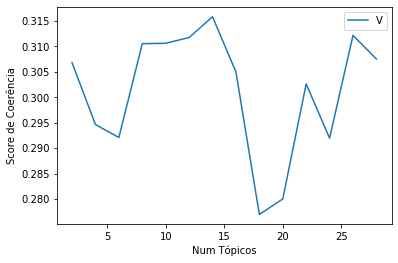

In [17]:
# Mostrando visualmente a quantidade de tópicos

limit=30; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Tópicos")
plt.ylabel("Score de Coerência")
plt.legend(("Valores de Coerência"), loc='best')
plt.show()

In [18]:
# Lista dos valores de coerência, para melhor identificar o ponto de inflexão do gráfico

for m, cv in zip(x, coherence_values):
    print("A quantidade de tópicos =", m, " tem um valor de coerência de ", round(cv, 4))

A quantidade de tópicos = 2  tem um valor de coerência de  0.3068
A quantidade de tópicos = 4  tem um valor de coerência de  0.2946
A quantidade de tópicos = 6  tem um valor de coerência de  0.2921
A quantidade de tópicos = 8  tem um valor de coerência de  0.3105
A quantidade de tópicos = 10  tem um valor de coerência de  0.3106
A quantidade de tópicos = 12  tem um valor de coerência de  0.3117
A quantidade de tópicos = 14  tem um valor de coerência de  0.3158
A quantidade de tópicos = 16  tem um valor de coerência de  0.305
A quantidade de tópicos = 18  tem um valor de coerência de  0.277
A quantidade de tópicos = 20  tem um valor de coerência de  0.28
A quantidade de tópicos = 22  tem um valor de coerência de  0.3026
A quantidade de tópicos = 24  tem um valor de coerência de  0.292
A quantidade de tópicos = 26  tem um valor de coerência de  0.3121
A quantidade de tópicos = 28  tem um valor de coerência de  0.3075


Aqui conseguimos determinar a melhor quantidade de tópicos a serem analisados, que é 8 tópicos

In [30]:
# Vamos agora construir de fato o modelo LDA

lda_model = LdaMulticore(corpus=corpus,
                        id2word=id2word,
                        num_topics=4, 
                        random_state=42,
                        chunksize=100,
                        passes=10,
                        per_word_topics=True)

In [31]:
# Computar a perplexidade do modelo (quanto menor, melhor)

print('\nPerplexidade: ', lda_model.log_perplexity(corpus))


Perplexidade:  -7.022800038232651


In [32]:
# Computar o Score de Coerência

coherence_model_lda = CoherenceModel(model=lda_model, texts=lista, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nScore de Coerência: ', coherence_lda)


Score de Coerência:  0.30540904699089305


In [33]:
# Visualização dos tópicos em clusters

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.142831  0.033586       1        1  30.471596
0     -0.294396  0.042321       2        1  29.462015
1      0.162589 -0.340056       3        1  20.458256
3      0.274638  0.264149       4        1  19.608139, topic_info=            Term          Freq         Total Category  logprob  loglift
1     presidente  27549.000000  27549.000000  Default  30.0000  30.0000
46   coronavirus  19127.000000  19127.000000  Default  29.0000  29.0000
39        corona  18798.000000  18798.000000  Default  28.0000  28.0000
2      bolsonaro  35459.000000  35459.000000  Default  27.0000  27.0000
463         casa  10090.000000  10090.000000  Default  26.0000  26.0000
..           ...           ...           ...      ...      ...      ...
263   brasileiro   1609.498047   3026.192383   Topic4  -4.8088   0.9978
360        falar   1709.682495   4100.103027   Topic4  -4.7484   0.7545
254         nada   1625.222900   4859.247559   Topic4  -4.7990   0.5340
2      bolsonaro   1996.411133  35459.648438   Topic4  -4.5933  -1.2478
136        agora   1513.293701   8097.066406   Topic4  -4.8704  -0.0480

[195 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
533       4  0.999253    abner
387       1  0.999533    abril
96        2  0.999792   acabar
136       1  0.234159    agora
136       2  0.285042    agora
...     ...       ...      ...
389       4  0.192729     vida
42        2  0.999927    virus
340       4  0.999143    volta
156       2  0.999572   voltar
364       4  0.999466  vontade

[188 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 4])

In [41]:
# Escolhe o modelo

optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.025*"cada" + 0.024*"mano" + 0.022*"comer" + 0.019*"dps" + 0.019*"vez" + '
  '0.019*"melhor" + 0.017*"presidente" + 0.014*"nada" + 0.014*"casa" + '
  '0.012*"entao"'),
 (1,
  '0.200*"bolsonaro" + 0.030*"merda" + 0.030*"prior" + 0.024*"pronunciamento" '
  '+ 0.023*"falar" + 0.018*"foraprior" + 0.015*"eduardo" + 0.013*"manu" + '
  '0.012*"tv" + 0.010*"bbb"'),
 (2,
  '0.040*"bbb" + 0.029*"coronavirus" + 0.024*"bilhao" + 0.018*"pandemia" + '
  '0.015*"muito" + 0.014*"paredao" + 0.014*"gente" + 0.014*"brasil" + '
  '0.013*"oq" + 0.010*"tirar"'),
 (3,
  '0.122*"corona" + 0.066*"coronavirus" + 0.061*"virus" + 0.034*"pandemia" + '
  '0.014*"brasil" + 0.013*"mundo" + 0.011*"agora" + 0.010*"saude" + '
  '0.009*"novo" + 0.009*"pegar"'),
 (4,
  '0.065*"acabar" + 0.060*"quando" + 0.054*"coronavirus" + 0.020*"casa" + '
  '0.018*"cabelo" + 0.016*"alguem" + 0.012*"final" + 0.011*"primeiro" + '
  '0.010*"caso" + 0.009*"logo"'),
 (5,
  '0.031*"casa" + 0.026*"pandemia" + 0.025*"coisa" + 0.024*"d

In [42]:
# Encontrar qual o principal tópico em cada tweet

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=lista):
    # Output
    sent_topics_df = pd.DataFrame()

    # Seleciona o principal tópico de cada tweet
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Calcula o principal tópico, o percentual de contribuição e as palavras chaves de cada tweet
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => mostra o principal tópico
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Principal_Topico', 'Perc_Contributicao', 'Palavras_Chave']

    # Inclui o texto original no final do DataFrame
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [43]:
# roda a função de calcular os principais tópicos de cada tweet

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=lista)

In [44]:
# Formata o DataFrame

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Index_DF_Original', 'Principal_Topico', 'Perc_Contrib_Topico', 'Palavras_Chave', 'Tweets']

In [45]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Principal_Topico')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contributicao'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topico', "Topico_Perc_Contrib", "Palavras_Chave", "Tweet"]

# Show
sent_topics_sorteddf_mallet

,Topico,Topico_Perc_Contrib,Palavras_Chave,Tweet
0,0.0,0.9182,"cada, mano, comer, dps, vez, melhor, president...","[tao, pandemia, impossivel, tambem, ter, vazio..."
1,1.0,0.9308,"bolsonaro, merda, prior, pronunciamento, falar...","[total, parar, foco, logo, https, foraprior, h..."
2,2.0,0.9437,"bbb, coronavirus, bilhao, pandemia, muito, par...","[bilhao, paredao, filho, mes, apolo, gente, oq..."
3,3.0,0.9400,"corona, coronavirus, virus, pandemia, brasil, ...","[pandemia, crise, ficaemcasa, trabalhar, pegar..."
4,4.0,0.9100,"acabar, quando, coronavirus, casa, cabelo, alg...","[casa, logo, nao, quando, jeito, lado, tu, me,..."
5,5.0,0.9470,"casa, pandemia, coisa, depois, passar, gente, ...","[gosto, dificil, casa, tbm, deixar, avo, coron..."
6,6.0,0.9473,"bolsonaro, presidente, oms, isolamento, pronun...","[criticar, serasse, golpe, oms, ditadura, hj, ..."
7,7.0,0.9500,"presidente, brasil, povo, bolsonaro, deus, bra...","[conjunto, tal, atual, fa, comunista, presiden..."
8,8.0,0.9249,"bolsonaro, corona, tomar, cu, kkkkkkk, casa, p...","[pe, casa, nao, bolsonaro, homem, mae, irmao, ..."
9,9.0,0.9307,"bolsonaro, nacional, pos, rede, outro, comecou...","[todo, falar, santo, paz, dar, nome, nacional,..."


In [46]:
# Numero de tweets por topico

topic_counts = df_topic_sents_keywords['Principal_Topico'].value_counts()

# Porcentagem de tweets por tópico
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Número do tópico e suas palavras chave
topic_num_keywords = df_topic_sents_keywords[['Principal_Topico', 'Palavras_Chave']]

# Concatena as colunas
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Renomeia as colunas
df_dominant_topics.columns = ['Principal_Topico', 'Palavras_Chave', 'Qtd_Tweets', 'Perc_Tweets']

# Mostra o DataFrame
df_dominant_topics

,Principal_Topico,Palavras_Chave,Qtd_Tweets,Perc_Tweets
0.0,7.0,"presidente, brasil, povo, bolsonaro, deus, bra...",21882.0,0.0999
1.0,0.0,"cada, mano, comer, dps, vez, melhor, president...",30800.0,0.1406
2.0,8.0,"bolsonaro, corona, tomar, cu, kkkkkkk, casa, p...",20130.0,0.0919
3.0,1.0,"bolsonaro, merda, prior, pronunciamento, falar...",32108.0,0.1466
4.0,1.0,"bolsonaro, merda, prior, pronunciamento, falar...",20170.0,0.0921
...,...,...,...,...
219000.0,5.0,"casa, pandemia, coisa, depois, passar, gente, ...",NaN,NaN
219001.0,2.0,"bbb, coronavirus, bilhao, pandemia, muito, par...",NaN,NaN
219002.0,6.0,"bolsonaro, presidente, oms, isolamento, pronun...",NaN,NaN
219003.0,8.0,"bolsonaro, corona, tomar, cu, kkkkkkk, casa, p...",NaN,NaN


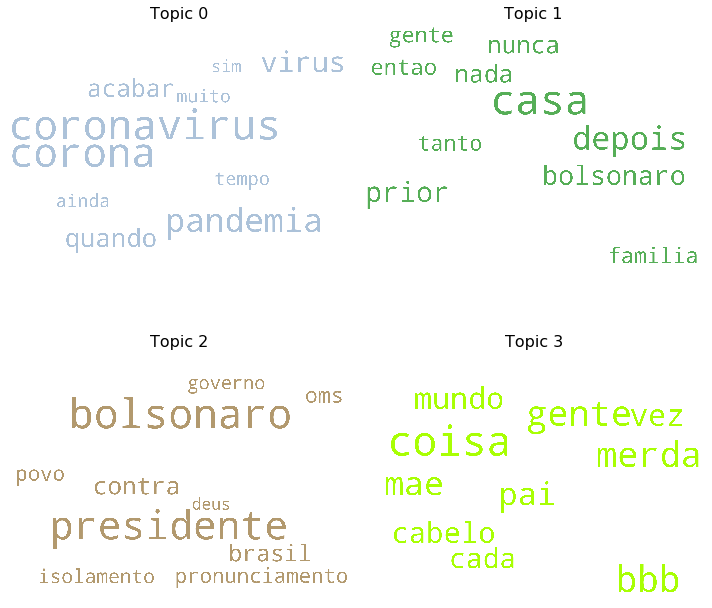

In [47]:
# Cria wordclouds

cols = [color for name, color in mcolors.XKCD_COLORS.items()]

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()